In [1]:
import torch.tensor as Tensor
import numpy as np
from typing import Final, List
import matplotlib.pyplot as plt

In [2]:
def generate_random_tensor(size : int) -> Tensor:
    '''
    Test Only! Do not use it when visualizing the tensor.
    '''
    if size <= 0:
        raise ArithmeticError("Size must be larger than 0!")
    data = []
    for i in range(size):
        temp : float = np.random.uniform(0.0, 1.0)
        t2 : float = 1.0 - temp
        data.append([temp, t2])
    return Tensor(data)

In [3]:
def generate_random_tensor2(timestamp_size : int, player_num : int) -> Tensor:
    '''
    Test Only! Do not use it when visualizing the tensor.
    '''
    if timestamp_size < 50:
        raise ArithmeticError("TimeStamp size must be at least 50!")
    if player_num < 4:
        raise ArithmeticError("Number of player must be at least 4!")
    data = []
    for i in range(timestamp_size):
        coordinates : List[List[int]] = np.random.randint(500, size=(2, player_num))
        coordinates2 : List[List[int]] = np.random.randint(500, size=(2, player_num))
        data.append([coordinates, coordinates2])
    return Tensor(data)

In [4]:
class VisualizationHelper:
    
    HEIGHT : Final[int] = 8
    MIN_WIDTH : Final[int] = 4
    WIDTH_DIVISOR : Final[int] = 6
    WIDTH_BIAS : Final[int] = 1
    
    def __init__(self, t : Tensor):
        self._tensor = t
        
    def plot_width(self, size : int) -> int:
        if size <= 0:
            raise ArithmeticError("Size must be larger than 0!")
        return max(self.MIN_WIDTH, size // self.WIDTH_DIVISOR + self.WIDTH_BIAS)

    @property
    def tensor(self) -> Tensor:
        return self._tensor

In [5]:
class WinRateVHelper(VisualizationHelper):
    
    def __init__(self, t : Tensor):
        super().__init__(t)
     
    def visualize_tensor(self) -> None:
        timestamp_size : int = self.tensor.size()[0]
        plt.figure(1, figsize=(self.plot_width(timestamp_size), self.HEIGHT))
        plt.xticks(list(range(0,timestamp_size + 1, 10)))
        plt.yticks(list(np.arange(0.0, 1.1, 0.1)))
        plt.plot(self.tensor)

In [6]:
class PlayerPositionVHelper(VisualizationHelper):
    
    MIN_WIDTH : Final[int] = 10
    MIN_HEIGHT : Final[int] = 10
    HEIGHT_DIVISOR : Final[int] = 52
    WIDTH_DIVISOR : Final[int] = 52
    
    def __init__(self, t : Tensor, width : int, height : int):
        super().__init__(t)
        self._time = self.tensor.size()[0]
        self._width = width
        self._height = height
        
    def plot_height(self) -> int:
        return max(self.MIN_HEIGHT, self.height // self.HEIGHT_DIVISOR + self.WIDTH_BIAS)
    
    def plot_width(self, size : int) -> int:
        if size <= 0:
            raise ArithmeticError("Size must be larger than 0!")
        return max(self.MIN_WIDTH, self.width // self.WIDTH_DIVISOR + self.WIDTH_BIAS)

    def visualize_tensor(self, t : int) -> None:
        if t < 0 or t >= self.time:
            raise ArithmeticError("@params time is out of bound!")
        plt.figure(1, figsize=(self.plot_width(self.width), self.plot_height()))
        plt.xticks(list(range(0,self.width + 1, 50)))
        plt.yticks(list(range(0,self.height + 1, 50)))
        data_time = self.tensor[t]
        groupA = data_time[0]
        groupB = data_time[1]
        plt.scatter(groupA[0], groupA[1], c ="red", s = 60)
        plt.scatter(groupB[0], groupB[1], c ="blue", s = 60)
    
    @property
    def time(self) -> int:
        return self._time
    
    @property
    def width(self) -> int:
        return self._width
    
    @property
    def height(self) -> int:
        return self._height

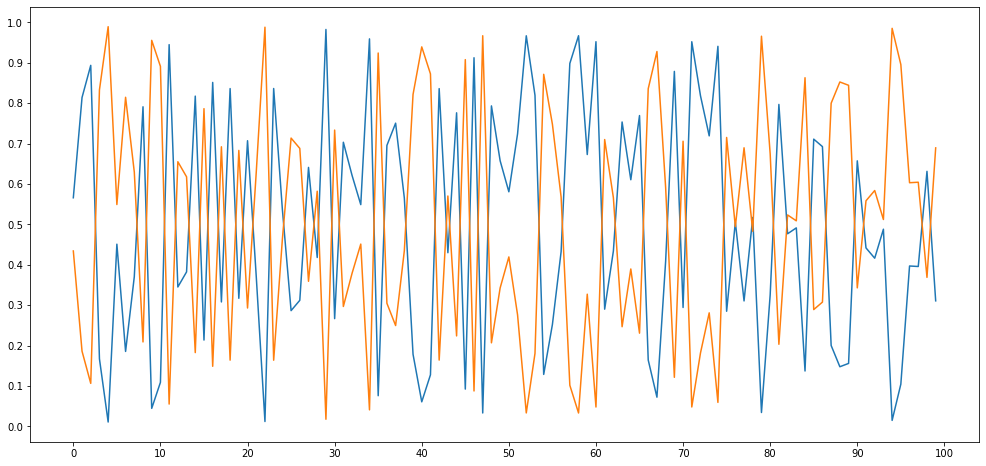

In [7]:
if __name__ == "__main__":
    helper = WinRateVHelper(generate_random_tensor(100))
    helper.visualize_tensor()

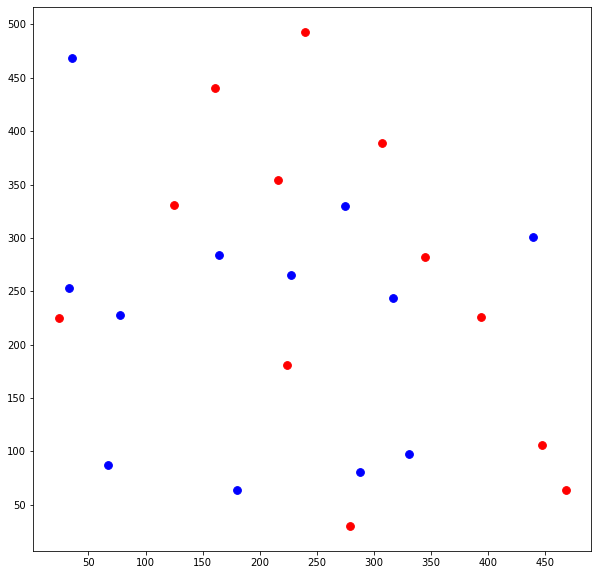

In [8]:
if __name__ == "__main__":
    helper2 = PlayerPositionVHelper(generate_random_tensor2(100, 12), 500, 500)
    helper2.visualize_tensor(0)